<!-- <div id="toc_container"> -->
<h2>Table of Contents</h2>
<ul class="toc_list">
  <a href="#1&nbsp;&nbsp;General-Analysis-Information">1&nbsp;&nbsp;General Analysis Information</a><br>
    <ul>
    <a href="#1.1&nbsp;&nbsp;Project-summary">1.1&nbsp;&nbsp;Project summary</a><br>
    <a href="#1.2&nbsp;&nbsp;Project-directory">1.2&nbsp;&nbsp;Project directory</a><br>
    </ul>
  <a href="#2&nbsp;&nbsp;Phylo-Seq-Obj">2&nbsp;&nbsp;Phylo Seq Object</a><br>
  <a href="#3&nbsp;&nbsp;Filter-taxa">3&nbsp;&nbsp;Filter taxa</a><br>
    <ul>
    <a href="#3.1&nbsp;&nbsp;By-taxa-mean">3.1&nbsp;&nbsp;By taxa mean</a><br>
    <a href="#3.2&nbsp;&nbsp;By-rel-abun">3.2&nbsp;&nbsp;By relative abundances</a><br>
    <a href="#3.3&nbsp;&nbsp;By-amp-conc">3.3&nbsp;&nbsp;By amp conc</a><br>  
    </ul>
  <a href="#4&nbsp;&nbsp;Alpha-div">4&nbsp;&nbsp;Alpha Diversity</a><br>
    <ul>
    <a href="#3.1&nbsp;&nbsp;Yaml-parameters">3.1&nbsp;&nbsp;Yaml parameters</a><br>
    <a href="#3.2&nbsp;&nbsp;Pipeline-run">3.2&nbsp;&nbsp;Pipeline run</a><br>
    </ul>
  <a href="#4&nbsp;&nbsp;Quality-control">4&nbsp;&nbsp;Quality control</a><br>
    <ul>
    <a href="#4.1&nbsp;&nbsp;Trimming">4.1&nbsp;&nbsp;Trimming</a><br>
    <a href="#4.2&nbsp;&nbsp;Non-bacterial-reads">4.2&nbsp;&nbsp;Non-bacterial reads</a><br>
    <a href="#4.3&nbsp;&nbsp;Sequencing-depth-distribution-per-flow-cell">4.3&nbsp;&nbsp;Sequencing depth distribution per flow cell</a><br>
    <a href="#4.4&nbsp;&nbsp;Read-counts-after-pre-process-filtering">4.4&nbsp;&nbsp;Read counts after pre process filtering</a><br>
    </ul>
</ul>

In [8]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.10")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)

Old packages: 'KernSmooth', 'MASS', 'backports', 'boot', 'broom', 'class',
  'dbplyr', 'digest', 'ellipsis', 'ggpubr', 'glmnet', 'glue', 'modelr', 'nlme',
  'nnet', 'pillar', 'pkgbuild', 'ps', 'purrr', 'recipes', 'reshape2', 'rlang',
  'sp', 'spatial', 'tibble', 'tidyr', 'tidyselect', 'tinytex', 'uuid', 'vctrs',
  'withr', 'xfun', 'xml2', 'zoo'



In [9]:
check_cran_pkg <- function(pkg){
    if(pkg %in% rownames(installed.packages())==FALSE){
        install.packages(pkg)
    }
}
check_bioc_pkg<-function(pkg){
    if(pkg %in% rownames(installed.packages())==FALSE){
        BiocManager::install(pkg)
    }
}
check_dev_pkg<-function(pkg){
    if (!requireNamespace("devtools", quietly = TRUE)){install.packages("devtools")}
    devtools::install_github(pkg)    
}

packages<-c("ape", "magrittr","ggplot2","knitr","Rcpp","expss")
for (i in packages){
    check_cran_pkg(i)
}

packages<-c("phyloseq","biomformat","tidyverse","yaml")
for (i in packages){
    check_bioc_pkg(i)
}

In [10]:
source("sources/ggrare.R") #github library: https://rdrr.io/github/gauravsk/ranacapa/
source("sources/miseqR.R")
source("sources/qiime2R.R") #github https://github.com/jbisanz/qiime2R
source('sources/abundances.R') #github https://github.com/microbiome/microbiome

library(biomformat)
library(ape)
library(cowplot)
library(data.table)
library(dplyr)
library("expss")
library(ggplot2)
library(phyloseq)
library(scales)
library(tibble)
library(vegan)
library(yaml)
library(ggpubr)
library(cluster)

<h2 id="1&nbsp;&nbsp;General-Analysis-Information">1&nbsp;&nbsp;General Analysis Information</h2>

<h3 id="1.1&nbsp;&nbsp;Project-summary">1.1&nbsp;&nbsp;Project summary</h3>

AIM 1 consists of a fecal extraction comparison using fresh-frozen fecal material from human donors, and artificial colonies. Samples were extracted using multiple methods, to be examined. The 16S rRNA gene was then sequenced using an Illumina MiSeq from three projects: NP0084-MB4, NP0084-MB5, NP0084-MB6. A summary of the three individual projects is included below:

- NP0084-MB4
- NP0084-MB5
- NP0084-MB6

<h3 id="1.2&nbsp;&nbsp;Project-summary">1.2&nbsp;&nbsp;Project directory</h3>

In [51]:
cgr_proj_dir='/DCEG/Projects/Microbiome/Analysis/NP0084_MB/20200410_2019.1'
proj_dir='/Users/slsevilla/Google Drive/MyDocuments_Current/Education/George Mason University/Dissertation/Data/Aim1/'
out_dir=paste(proj_dir,'output/',sep="")
img_dir=paste(proj_dir,out_dir,'img/',sep="")

<h2 id="2&nbsp;&nbsp;Phylo-Seq-Obj">2&nbsp;&nbsp;Phylo Seq Object</h2>

In [12]:
#Read OTUS
otus<-read_qza('../output/denoising/feature_tables/merged_filtered.qza')

#Read rooted tree
tree<-read_qza('../output/phylogenetics/rooted_tree.qza')
 
#Read Greengenes taxonomy file
taxonomy<-read_qza('../output/taxonomic_classification/classify-sklearn_silva-132-99-nb-classifier.qza')
 
#Create taxonomy table
tax_table = data.frame()
col = 1
row = 1

for (i in taxonomy$data$Taxon){
    tax_list = as.list(strsplit(as.character(i),";"))
    for (i in 1:lengths(tax_list)){
        tax_table[row,col] = tax_list[[1]][i]
        col = col + 1
    }
    col = 1
    row = row + 1
}
rownames(tax_table)<-taxonomy$data$Feature.ID
colnames(tax_table)<-c("Domain", "Phylum", "Class", "Order", "Family", "Genus", "Species")
tax_convert<-as.matrix(tax_table)  
 
#read metadata
metadata<-read.table('../manifest/m_cleaned.txt',sep='\t', header=T, row.names=1, comment="")
 
#Create phylo object
phy_obj<-phyloseq(otu_table(otus$data, taxa_are_rows = T), phy_tree(tree$data), tax_table(tax_convert), sample_data(metadata))

In [13]:
colnames(sample_data(phy_obj))

[1] "Source.PCR.Plate" "Run.ID"           "Project.ID"       "CGR.Sample.ID"   
 [5] "Sample.Type"      "Sample.Des"       "Subject.ID"       "Reciept"         
 [9] "Ext.Company"      "Ext.Kit"          "Ext.Robotics"     "Homo.Status"     
[13] "Homo.Method"      "Homo.Holder"      "input"            "filtered"        
[17] "denoised"         "merged"           "non.chimeric"     "D_0__Archaea"    
[21] "D_0__Bacteria"    "D_0__Eukaryota"   "Unassigned"       "frac_filtered"

In [14]:
phy_obj

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1818 taxa and 351 samples ]
sample_data() Sample Data:       [ 351 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 1818 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1818 tips and 1811 internal nodes ]

<h3> Review alpha metrics before filtering </h3>

Review metrics for the human samples only

In [15]:
sub_list<-c("Robogut","human_1")
phy_sub<-subset_samples(phy_obj, Sample.Des %in% sub_list)
phy_sub

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1818 taxa and 160 samples ]
sample_data() Sample Data:       [ 160 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 1818 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1818 tips and 1811 internal nodes ]

In [18]:
jpeg(paste(proj_dir,"/output/img/alpha_all.jpg",sep=""))

#Create 2x2 plot environment so that we can see all 4 metrics at once. 
par(mfrow = c(2, 2))

#Then plot each metric.
hist((estimate_richness(phy_sub,measures="Observed"))$Observed, main="Observed diversity", xlab="", breaks=10)
hist((estimate_richness(phy_sub,measures="Shannon"))$Shannon, main="Shannon diversity", xlab="", breaks=10)
hist((estimate_richness(phy_sub,measures="Simpson"))$Simpson, main="Simpson diversity", xlab="", breaks=10)
hist((estimate_richness(phy_sub,measures="ACE"))$ACE, main="ACE diversity", xlab="", breaks=10)
dev.off()

png 
  2

<h2 id="3&nbsp;&nbsp;Rarefaction-of-samples">3&nbsp;&nbsp;Rarefaction of Samples</h2>

In [19]:
#Create rarefaction curve
rare_curves<-function(phy_in,color_in,filename){
    #alt way to plot
    #rarecurve(t(otu_table(phy_obj)), step=1000)
    
    p <- ggrare(phy_in, step = 1000, color = color_in)
    png(filename)
    print(p)
    dev.off()
}

In [21]:
#Will determine how many samples would be present if raryfied to the number list provided
rare_values<-function(phy_in,read_in){
    df<-data.frame()
    for (i in read_in){
        sam_count = sum(metadata$non.chimeric>i)

        df[nrow(df)+1,"rarefaction_level"] = i
        df[nrow(df),"sample_count"] = sam_count
        df[nrow(df),"samples_dropped"] = 351-sam_count
        df[nrow(df),"per_samples_retained"] = (sam_count/351)*100
        if(nrow(df)>1){df[nrow(df),"per_diff"] = ((df[nrow(df)-1,"sample_count"]-df[nrow(df),"sample_count"])/df[nrow(df)-1,"sample_count"])*100}
        df[nrow(df),"study"] = sum(metadata$Sample.Type=="Study" & metadata$non.chimeric>i)
        df[nrow(df),"ext_cont"] = sum(metadata$Sample.Type=="Ext_Control" & metadata$non.chimeric>i)
        df[nrow(df),"ext_blank"] = sum(metadata$Subject.ID=="Water" & metadata$non.chimeric>i)
        df[nrow(df),"seq_cont"] = sum(metadata$Sample.Type=="Seq_Control" & metadata$non.chimeric>i)
        df[nrow(df),"study_rem"] = sum(metadata$Sample.Type=="Study") - sum(metadata$Sample.Type=="Study" & metadata$non.chimeric>i)
        df[nrow(df),"ext_cont_rem"] = sum(metadata$Sample.Type=="Ext_Control") - sum(metadata$Sample.Type=="Ext_Control" & metadata$non.chimeric>i)
        df[nrow(df),"seq_cont_rem"] = sum(metadata$Sample.Type=="Seq_Control") - sum(metadata$Sample.Type=="Seq_Control" & metadata$non.chimeric>i)
    }
    return (df)
}

rarefying sample NTC-PC04925-H-12
rarefying sample SC249366-PC04925-D-01
rarefying sample SC249382-PC04925-F-01
rarefying sample SC249387-PC04925-G-01
rarefying sample SC249391-PC04925-H-01
rarefying sample SC249406
rarefying sample SC249408-PC04925-E-02
rarefying sample SC249410-PC04925-F-02
rarefying sample SC249411-PC04925-G-02
rarefying sample SC249414-PC04925-H-02
rarefying sample SC249416-PC04925-A-03
rarefying sample SC249418-PC04925-B-03
rarefying sample SC249419-PC04925-C-03
rarefying sample SC249422-PC04925-D-03
rarefying sample SC249424-PC04925-E-03
rarefying sample SC249426-PC04925-F-03
rarefying sample SC249429-PC04925-G-03
rarefying sample SC249430-PC04925-H-03
rarefying sample SC249431
rarefying sample SC249432-PC04925-B-04
rarefying sample SC249433-PC04925-C-04
rarefying sample SC249435-PC04925-D-04
rarefying sample SC249436-PC04925-E-04
rarefying sample SC249437-PC04925-F-04
rarefying sample SC249440-PC04925-G-04
rarefying sample SC249441-PC04925-H-04
rarefying sample 

png 
  2

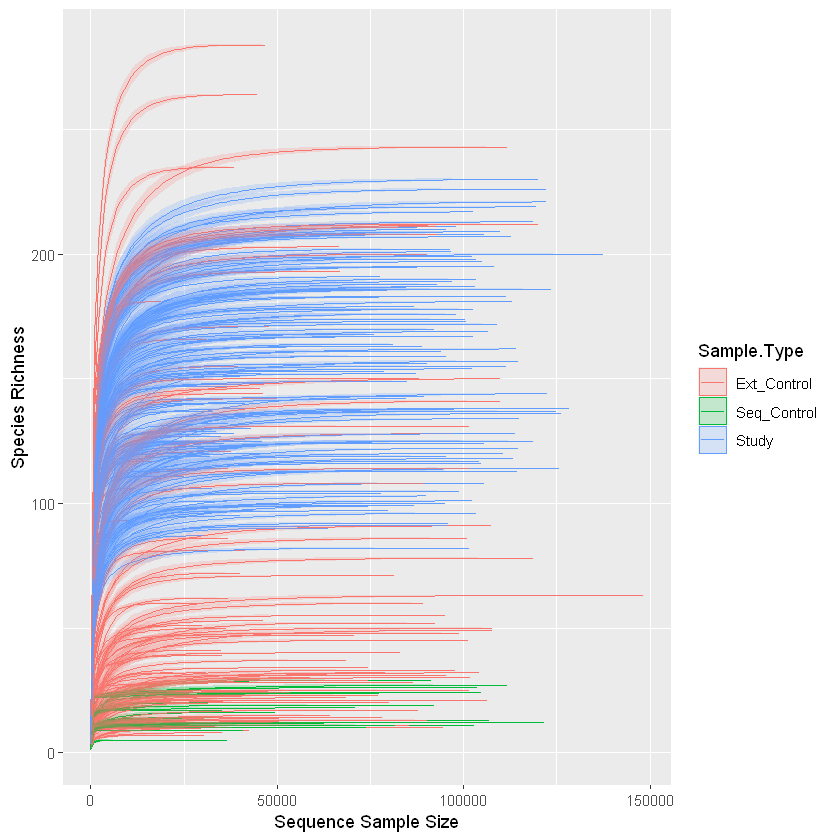

In [20]:
rare_curves(phy_obj,"Sample.Type",paste(proj_dir,"output/img/rarecurve_pre.png",sep=""))

#Start with large chunks for rare numbers
#read_list = seq(10000,60000,1000)
read_list = c(0,1000,10000,20000,30000,40000)
df_rare = rare_values(phy_obj,read_list)
df_rare

#rareyfy the dataset
phy_r = rarefy_even_depth(phy_obj, rngseed=1, sample.size=20000, replace=F) 
#sample.size=0.9*min(sample_sums(phy_fr) #alt way to decide the sample size
#phy_r = phy_obj %>% scale_reads(n=rare_val) #alt way to scale reads

#Create final curve
rare_curves(phy_r,"Sample.Type",paste(proj_dir,"output/img/rarecurve_post.png",sep=""))

In [25]:
#Plot final by subject ID
png(paste(proj_dir,"output/img/rarecurve_post_kit.png",sep=""))
ggrare(phy_r,color = "Sample.Type", step=1000) + facet_wrap(~Ext.Kit)
dev.off()

rarefying sample SC249387-PC04925-G-01
rarefying sample SC249391-PC04925-H-01
rarefying sample SC249408-PC04925-E-02
rarefying sample SC249410-PC04925-F-02
rarefying sample SC249411-PC04925-G-02
rarefying sample SC249414-PC04925-H-02
rarefying sample SC249418-PC04925-B-03
rarefying sample SC249419-PC04925-C-03
rarefying sample SC249424-PC04925-E-03
rarefying sample SC249426-PC04925-F-03
rarefying sample SC249429-PC04925-G-03
rarefying sample SC249430-PC04925-H-03
rarefying sample SC249432-PC04925-B-04
rarefying sample SC249433-PC04925-C-04
rarefying sample SC249435-PC04925-D-04
rarefying sample SC249436-PC04925-E-04
rarefying sample SC249437-PC04925-F-04
rarefying sample SC249440-PC04925-G-04
rarefying sample SC249441-PC04925-H-04
rarefying sample SC249444
rarefying sample SC249445-PC04925-B-05
rarefying sample SC249447-PC04925-C-05
rarefying sample SC249448-PC04925-A-11
rarefying sample SC249448-PC04925-D-05
rarefying sample SC249449-PC04925-E-05
rarefying sample SC249453-PC04925-F-05

png 
  2

In [27]:
#Summarize data
temp = as.data.frame(sample_data(phy_r))
table(temp$Sample.Type)
table(temp$Subject.ID)
table(temp$Run.ID)


Ext_Control Seq_Control       Study 
        117          30         135 


  D6300   D6305   D6306   D6310   D6311 DZ35298 DZ35316 DZ35322 MSA1000 MSA1001 
     53       5       5      16       1      47       4      23       4       5 
MSA1002 MSA1003   Water human_1 
      5       5      21      88 


Run1 Run2 Run3 Run4 
  64   59   60   99 

<h2> Seq Assessment <h2>

<h3> Code <h3>

In [30]:
phy_seq <- function(phy_in){
    #glom to tax level, subset for only seq controls
    seq_obj = tax_glom(phy_in,taxrank="Genus") #only merges genera that have the same upper taxonomy
    seq_obj = subset_samples(seq_obj,Sample.Type=="Seq_Control" & Sample.Des!="Seq_Blank")
    return(seq_obj)
}

In [31]:
otu_extract <- function(phy_in){
    # Extract abundance matrix from the phyloseq object
    OTU1 = as(otu_table(phy_in), "matrix")
    if(taxa_are_rows(phy_in)){OTU1 <- t(OTU1)} # transpose
    OTUdf = as.data.frame(OTU1)# Coerce to data.frame
    return(OTUdf)
}

In [33]:
tax_extract <- function(phy_in){
    #extract taxonomy information into dataframe
    TAXdf = tax_table(phy_in)
    return(TAXdf)
}

In [36]:
otu_tax_clean <- function(OTU_in,TAX_in){
    #Remove zero cols
    OTUdf_clean = OTU_in[, which(colSums(OTU_in) != 0)]

    #rename col from features to genus
    for (i in colnames(OTU_in)){
        newname = paste(as.character(TAX_in[i,"Family"]),as.character(TAX_in[i,"Genus"]),sep="")
        
        #standardize gg naming
        newname = trimws(newname) #remove first space in gg naming
        newname = sub(" g__","g__",newname)
        newname = sub("\\[","",newname)
        newname = sub("\\]","",newname)
        
        if(is.na(newname)){
            next;
        } else{
            names(OTUdf_clean)[names(OTUdf_clean) == i] <- newname
        }
    }
    
    #add metadata col
    metadata<-read.table('../manifest/m_cleaned.txt',sep='\t', header=T, row.names=1, comment="")
    for (a in rownames(OTUdf_clean)){
        OTUdf_clean[a,"Subject.ID"] = metadata[a,"Subject.ID"]
    }
    OTUdf_clean = data.frame(OTUdf_clean,stringsAsFactors=FALSE)
    
    return(OTUdf_clean)
}

In [40]:
#Read in taxonomy file
CONTdf = read.csv('../taxonomy/Taxonomy_Complete.csv',stringsAsFactors = FALSE)

#Convert the tax file to SILVA naming with "D_5__"
CONTdf_s = CONTdf
for (i in 1:nrow(CONTdf)){
    old = as.character(CONTdf[i,"Genus"])
    new = paste("D_5__",old,sep="")
    new = gsub(" ", ".", new, fixed = TRUE)
    CONTdf_s[i,"Genus"] = new
    
    old = as.character(CONTdf[i,"Family"])
    new = paste("D_4__",old,sep="")
    new = gsub(" ", ".", new, fixed = TRUE)
    CONTdf_s[i,"Family"] = new
}

#Convert the tax file to gg naming with "f"
CONTdf_g = CONTdf
for (i in 1:nrow(CONTdf)){
    old = as.character(CONTdf[i,"Genus"])
    new = paste("g__",old,sep="")
    new = gsub(" ", ".", new, fixed = TRUE)
    CONTdf_g[i,"Genus"] = new
    
    old = as.character(CONTdf[i,"Family"])
    new = paste("f__",old,sep="")
    new = gsub(" ", ".", new, fixed = TRUE)
    CONTdf_g[i,"Family"] = new
}

In [39]:
#Create TP,FP,FN dataframe
bench_compare <- function(OTUdf_in,CONTdf_in){
    
    F1df = OTUdf_in
    F1df$Sample_names = rownames(F1df) #create col of sample_names
    
    #For each of the controls in the cleaned df
    for (cont in unique(OTUdf_in$Subject.ID)){
        temp=filter(CONTdf_in, get(cont) !=0) #create df of taxa related to control
        
        #Create taxa list, merging family and genus - this will help avoid id errors from taxonomic differences
        #IE one taxa labeled at the genus level may be from family1 and the same taxa may also be from family2
        taxa_list=list()
        for (x in rownames(temp)){taxa_list = c(taxa_list,paste(temp[x,"Family"],temp[x,"Genus"],sep=""))}  
        
        #Create list of samples that match the control
        sample_list = filter(F1df, Subject.ID == cont)$Sample_names
        
        #If the data is not in the df (FN), then add the taxa as a new col
        for (taxa in taxa_list){ 
            if(!(taxa %in% unique(colnames(F1df)))){
                F1df[taxa[!(taxa %in% colnames(F1df))]] = 0
            } 
        }

        for (sample in sample_list){
            for (col in unique(colnames(F1df))[unique(colnames(F1df)) != "Subject.ID" & unique(colnames(F1df)) != "Sample_names"]){ 
                #removes subjectID, sample_names cols from loop
                value_check = F1df[sample,col]

                if(col %in% taxa_list && value_check > 0){ #column matches expected taxa, has features
                    F1df[sample,col] = "TP"
                } else if (col %in% taxa_list && value_check == 0){ #column matches expected taxa, no features
                    F1df[sample,col] = "FN"
                } else if ((!col %in% taxa_list) && value_check > 0){ #column doesnt match expected taxa, has features
                    F1df[sample,col] = "FP"
                } else{ #column doesnt match expected taxa, has no features
                    next
                }
            }
        }
    }
    return(F1df)
}

In [43]:
#Create counts of FP, FN, TP
bench_counts <- function(OTUdf_in,F1_in){
    F1df_counts = subset(OTUdf_in, select=c("Subject.ID"))

    for (sample in rownames(F1df)){
        FN = rowSums(F1_in=="FN")[sample][[1]]
        FP = rowSums(F1_in=="FP")[sample][[1]]
        TP = rowSums(F1_in=="TP")[sample][[1]]

        F1df_counts[sample,"check"]= FN + TP
        F1df_counts[sample,"FN"] = FN
        F1df_counts[sample,"FP"] = FP
        F1df_counts[sample,"TP"] = TP
        F1df_counts[sample,"TAR"] = TP / (TP + FP)
        F1df_counts[sample,"TDR"] = TP / (TP + FN)

        num = F1df_counts[sample,"TAR"]*F1df_counts[sample,"TDR"]
        den = F1df_counts[sample,"TAR"]+F1df_counts[sample,"TDR"] 
        F1df_counts[sample,"F1"] = 2*(num/den)
        F1df_counts[sample,"Subject.ID"] = OTUdf_in[sample,"Subject.ID"]
    }
    return(F1df_counts)
}

In [47]:
plot_violin <- function(df_in,x_lab,y_ax,y_lab,col_in){
    p = ggplot(df_in, aes(x=get(x_lab), y=get(y_ax), color=get(col_in))) + 
        geom_violin(trim=FALSE) + 
        labs(color = col_in) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1),
              axis.title.x = element_blank(), 
             legend.position = "none") + 
        ylab(y_lab) +
        stat_summary(fun.data=mean_sdl, color="red")
    return (p)
}

In [53]:
plot_f1_violin <- function(F1_in,x_list,y_list,id_in,title,ftype){
    
    p_1 = plot_violin(F1_in,id_in,x_list[1],y_list[1],id_in)
    p_2 = plot_violin(F1_in,id_in,x_list[2],y_list[2],id_in)
    p_3 = plot_violin(F1_in,id_in,x_list[3],y_list[3],id_in)

    #Create count violin plots
    fig = ggarrange(p_1, p_2, p_3, 
              labels = c("A", "B", "C"),
              title = title,
              #common.legend = TRUE,
              ncol = 2, nrow = 2)
    annotate_figure(fig, #https://rpkgs.datanovia.com/ggpubr/reference/annotate_figure.html
                   top = text_grob(title, color = "blue", face = "bold", size = 14)
    )
    
    ggsave(paste(out_dir,"/img/violin_f1_",ftype,"_seqassess.jpg",sep=""))
}

In [121]:
tstat_paired_f1 <- function(f1_in,subgroup_in){
    
    df_out = data.frame()
    
    cal_list = c("TAR","TDR","F1")
    
    for (cal in cal_list){
    
        comb_list = combn(unique(f1_in[,subgroup_in]),2)
        count=1
        
        for (i in 1:(length(comb_list)/2)){
            
            tstatdf=data.frame()
            var1 = as.character(comb_list[count])
            var2 = as.character(comb_list[count+1])
            count=count+2
            
            df = f1_in %>%
                filter(f1_in[,subgroup_in] == var1 | f1_in[,subgroup_in] == var2) %>%
                select(subgroup_in, cal)
            
            var_len = length(unique(df[,cal]))
            if(var_len<3){
                if(var_len==1){print(paste('Values are equal:', var1, "and", var2, sep=" "))}
                else{print(paste('Values are essentially equal:', var1, "and", var2, sep=" "))}
            } else{
                tmp = t.test(get(cal) ~ get(subgroup_in), data = df)
                tstatdf[nrow(tstatdf)+1,"level"] = cal
                tstatdf[nrow(tstatdf),"comparison"] = paste(var1,var2,sep="_")
                tstatdf[nrow(tstatdf),"pval"] = tmp$p.value
                if(tmp$p.value<0.05){
                    tstatdf[nrow(tstatdf),"sig"] = "sig"
                } else{
                    tstatdf[nrow(tstatdf),"sig"] = "ns"
                }

                df_out = bind_rows(df_out,tstatdf)
            }
            

        }
    }
        
    return(df_out)
}

In [123]:
cal_relabun <- function(df_in){
    temp = df_in
    temp$Total = rowSums(df_in[,c(-(ncol(df_in)))])
    col_list = subset(colnames(temp),colnames(temp)!="Subject.ID" & colnames(temp)!="Total")

    #cal_relabund <- function(x){}
    for (row in rownames(temp)){
        for (col in col_list){
            val = temp[row,col]
            if(val==0){
                next
            } else{
                temp[row,col] = val/temp[row,"Total"]
            }
        }
    }
    return(temp)
}

In [136]:
cal_EO <- function(df_in,contdf_in,bench_in,title_in){
    count=1
    plot_list = list()
    EOdf_merged = data.frame()
    eo_out = data.frame()
    
    #For each of the controls in the cleaned df
    for (cont in unique(df_in$Subject.ID)){

        taxdf = create_taxadf(cont,contdf_in)
        taxa_list=taxdf$taxa.id
        
        #Create list of samples that match the control
        sample_list = filter(RAdf, Subject.ID == cont)$Sample_name
        EOdf= data.frame()
        
        for (taxa in taxa_list){
            for(sample in sample_list){
                EOdf[nrow(EOdf)+1,"Sample_name"] = sample
                EOdf[nrow(EOdf),"taxa.id"] = taxa
                EOdf[nrow(EOdf),"Subject.ID"] = cont
                EOdf[nrow(EOdf),"exp"] = taxdf[taxa,cont]
                #EOdf[nrow(EOdf),"bench"] = bench_in

                if(is.null(df_in[sample,taxa])){
                    next
                } else{
                    EOdf[nrow(EOdf),"obs"] = df_in[sample,taxa]
                }
            }
        }
        EOdf_merged = rbind(EOdf_merged,EOdf) #Merge dfs
        
        #Create scatter plots
        plot_list[[count]] = plot_EO(EOdf,cont)
        count=count+1
        
        #Calc stats
        EOdf[is.na(EOdf)] = 0
        temp = cal_EO_stattest(EOdf,cont,bench_in)
        eo_out = rbind(eo_out,temp) #merge df       
    }
    
    #print plots
    fig = ggarrange(plot_list[[1]], plot_list[[2]], plot_list[[3]], plot_list[[4]], plot_list[[5]], plot_list[[6]], 
              labels = c("A", "B", "C", "D", "E", "F"),
              #top = as.character(title_in),
              #common.legend = TRUE#,
              ncol = 2, nrow = 3)
    annotate_figure(fig, top = text_grob(title_in, color = "blue", face = "bold", size = 14)
    )
    ggsave(paste(out_dir,"/img/scatter_",bench_in,".jpg",sep=""))

    return(eo_out)
}

In [138]:
create_taxadf <- function(cont,contdf_in){
    taxdf=filter(contdf_in, get(cont) !=0) #create df of taxa related to control
    taxdf$taxa.id=paste(taxdf$Family,taxdf$Genus,sep="") #create fam/genus col
    taxdf = taxdf[,c("taxa.id",cont),drop=FALSE] #remove all cols but the merged and control col
    taxdf = aggregate(get(cont) ~ taxa.id, data = taxdf, sum) #collapse df for any dups    
    names(taxdf)[2] = cont
    rownames(taxdf) = taxdf$taxa.id
    return(taxdf)
}

In [139]:
plot_EO <- function(df_in,cont_in){
    my_data=subset(df_in,Subject.ID==cont_in)

    p = ggscatter(my_data, x = "obs", y = "exp", 
              add = "reg.line", conf.int = TRUE, 
              cor.coef = TRUE, cor.method = "pearson",
              xlab = "Expected Rel Abunance (%)", ylab = "Observed Rel Abun (%)") +
        ggtitle(paste("Rel Abun:",cont_in,sep=""))
    return(p)
}

In [140]:
cal_EO_stattest <- function(df_in,cont_in,bench_in){
    my_data=subset(df_in,Subject.ID==cont_in)
    df_out=data.frame()
    
    df_out[nrow(df_out)+1,"bmark"] = bench_in
    df_out[nrow(df_out),"cont"] = cont_in
    df_out[nrow(df_out),"shapiro"] = shapiro.test(my_data$obs)$p.value
    df_out[nrow(df_out),"spear.p"] = cor.test(my_data$obs,my_data$exp,method = "spearman")$p.value
    df_out[nrow(df_out),"spear.rho"] = cor.test(my_data$obs,my_data$exp,method = "spearman")$estimate[[1]]
    return(df_out)
}

In [179]:
#Create averaged relative abundance df
create_av_RAdf <- function(RAdf_in,bench_in="",var_in=""){
    #tmp = aggregate(RAdf_in[,1:(ncol(RAdf_in)-3)], list(RAdf_in$Subject.ID), mean)
    tmp = RAdf_in[,1:(ncol(RAdf_in)-3)]
    tmp$Group.1 = rownames(tmp)
    rownames(tmp) = c()
    tmp$bmark=RAdf_in$Subject.ID
    #tmp$db = benchmarkdf[var_in,"tax.ref"]
    return(tmp)
}

In [189]:
#Add expected values to RA average dfs
RAdf_addcontrols<-function(cont_in,df_in){
    
    tmp=get(df_in)
    cont_leng = length((unique(OTUdf_clean$Subject.ID)))
    cont_list = unique(OTUdf_clean$Subject.ID)
    
    for(i in 1:cont_leng){
        #cont = as.character(tmp[i,"Group.1"])
        cont = as.character(cont_list[i])
        taxadf = create_taxadf(cont,get(cont_in))
        tmp_count = nrow(tmp)+1
        
        for(tx_row in 1:nrow(taxadf)){
            tmp[tmp_count,"Group.1"]=cont
            tmp[tmp_count,taxadf[tx_row,"taxa.id"]] = taxadf[tx_row,cont]
            tmp[tmp_count,"bmark"]=cont
        }
        
    }
    tmp[is.na(tmp)] = 0 
    return(tmp)
}

In [182]:
calc_dist <- function(RA_in,CONTdf_in){
    rownames(RA_in)=paste(RA_in$Group.1,RA_in$bmark,sep="-")
    RA_in = subset(RA_in, select = -c(Group.1,bmark))

    taxa_list<-unique(paste(CONTdf_in$Family,CONTdf_in$Genus,sep=""))
    df_clean = RA_in[,colnames(RA_in) %in% taxa_list] #remove cols not expected

    df_out = vegdist(df_clean,method="bray")   
    return(df_out)
}

In [159]:
plot_dist_cluster <- function(df_in,ref_in){
    fname = paste(out_dir,"/img/hclust_seqasses_bc_",ref_in,".png",sep="")
    png(fname,width = 900, height = 600)
    p = plot(hclust(df_in), cex = .9, main = "Sequence Assessment - Bray-Curtis Dissimilarity",
             xlab="Sequencing Controls", sub="")
    dev.off()
}

In [213]:
plot_dist_violin <- function(df_in,ref_in){
    df_in = as.data.frame(as.matrix(df_in))
    
    df_plot=data.frame()
    for (row in rownames(df_in)){
        splits = strsplit(row,"-")
        if(splits[[1]][2]==splits[[1]][1]){
            next
        }else{
            df_plot[nrow(df_plot)+1,"dist"]=df_in[row,paste(splits[[1]][2],splits[[1]][2],sep="-")] #col name is exp control
            df_plot[nrow(df_plot),"name"]=splits[[1]][2]
        }
    }

    p = ggplot(df_plot, aes(x=name, y=dist, color=name)) + 
            geom_violin(trim=FALSE) + 
            labs(color = df_plot$name) +
            theme(axis.text.x = element_text(angle = 90, hjust = 1),
                  axis.title.x = element_blank(), 
                 legend.position = "none") + 
            xlab("Sequence Control") +
            ylab("Bray-Curtis Dissimilarity") +
            stat_summary(fun.data=mean_sdl, color="red")
    
    
    fig = ggarrange(p, 
              #labels = c("A"),
              #top = as.character(title_in),
              #common.legend = TRUE#,
              ncol = 1, nrow = 1)
    annotate_figure(fig, top = text_grob("Bray-Curtis Dissimilarity", color = "blue", face = "bold", size = 14)
    )
    ggsave(paste(out_dir,"/img/violin_bc_summary_seqassess_",ref_in,".jpg",sep=""))
    return(df_plot)

}

In [250]:
adonis_bc <- function(df_in){

    df_out=data.frame()
    
    st = adonis(df_in[,1] ~ name,
                data=df_in, permutations = 99, method="bray")
    df_out[nrow(df_out)+1,"comparison"] = "bray-curtis"
    df_out[nrow(df_out),"pval"] = as.numeric(st$aov.tab$"Pr(>F)"[1])
        
    if(df_out[nrow(df_out),"pval"]<0.05){
        df_out[nrow(df_out),"sig"] = "sig"
    } else{
        df_out[nrow(df_out),"sig"] = "ns"
    }   
    
    dist_s = vegdist(subset(dissdf_s,select = -c(bmark,Group.1)),na.rm=TRUE)

        
    df_out[nrow(df_out)+1,"homo_s"] = anova(betadisper(dist_s,dissdf_s$bmark))$"Pr(>F)"[1]
    
    return(df_out)
}

<h3> Production Run <h3>

In [65]:
#Find averages reads
mean(rowSums(otu_extract(phy_seq(phy_obj))))


[1] 62571.84

In [218]:
#Create raryified object
phy_r = rarefy_even_depth(phy_obj, rngseed=1, sample.size=20000, replace=F) 

#Create glomed, subsetted obj
seq_obj = phy_seq(phy_r)
remove(phy_r)

#Create OTUdf
OTUdf = otu_extract(seq_obj)
    
#Create TAXdf
TAXdf = tax_extract(seq_obj)
    
#Clean df's
OTUdf_clean = otu_tax_clean(OTUdf,TAXdf)

#Create TP,FP,FN df
tax_ref = 'silva'
if(tax_ref=='silva'){
    CONTdf_use = CONTdf_s
    F1df = bench_compare(OTUdf_clean, CONTdf_use)
} else{
    CONTdf_use = CONTdf_g
    F1df = bench_compare(OTUdf_clean, CONTdf_use)
}

#Create TP,FP,FN counts    
F1df_counts = bench_counts(OTUdf_clean,F1df)
temp = F1df_counts
temp$sample_name = rownames(temp)
mergedf_f1stats = temp

#Create violin plots for each control - counts
x_list = c("FN","TP","FP")
y_labs = c("False negative","True positive", "False positive")
plot_f1_violin(F1df_counts,x_list,y_labs,"Subject.ID","Sequencing Controls","counts")

#Create violin plots for each control - summary
x_list = c("TAR","TDR","F1")
y_labs = c("Taxonmic Accuracy Rate","Taxonmic Detection Rate", "F-Measure")
plot_f1_violin(F1df_counts,x_list,y_labs,"Subject.ID","Sequencing Controls","summary")

#T-tests
mergedf_f1stats_f = subset(mergedf_f1stats,Subject.ID != "D6311")
tstatdf = tstat_paired_f1(mergedf_f1stats_f,"Subject.ID")
write.csv(tstatdf,paste(out_dir,"bench_files/ttest_stats_seqassess.csv",sep=""))

#Create scatter plots
#Determine expected to observed scatter plots, normality, spearman coeff 
title = paste("Scatterplots of controls: ","Seq Assessment",sep="")
EOdf_stats = cal_EO(RAdf,CONTdf_use,"seqasses",title)    
EOdf_stats_merged = EOdf_stats

#calculate relative abundance
RAdf = cal_relabun(OTUdf_clean)
RAdf$Sample_name = rownames(RAdf)

#Create averaged OTU df
dissdf = create_av_RAdf(RAdf)
dissdf_s = dissdf

#Calculate bray-curtis distances
RAdf_oe = RAdf_addcontrols("CONTdf_s","dissdf_s")
RAdf_clean = calc_dist(RAdf_oe,CONTdf_s)

#Create hclust
plot_dist_cluster(RAdf_clean,"s")
Distdf = plot_dist_violin(RAdf_clean,"s")
Distdf_merged = Distdf

adonis_stats = adonis_bc(Distdf_merged)
adonis_stats

`set.seed(1)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1); .Random.seed` for the full vector

...

69 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


NTC-PC04925-H-12SC249366-PC04925-D-01SC249382-PC04925-F-01SC249406SC249416-PC04925-A-03

...

611OTUs were removed because they are no longer 
present in any sample after random subsampling


...

Warning message:
"Removed 1 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."
Warning message in as_grob.default(plot):
"Cannot convert object of class character into a grob."
Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_seg

[1] "Values are equal: MSA1000 and MSA1001"
[1] "Values are essentially equal: MSA1000 and D6305"
[1] "Values are essentially equal: MSA1000 and D6306"
[1] "Values are essentially equal: MSA1001 and D6305"
[1] "Values are essentially equal: MSA1001 and D6306"
[1] "Values are equal: D6305 and D6306"


Warning message in cor(rank(x), rank(y)):
"the standard deviation is zero"
Warning message in cor(rank(x), rank(y)):
"the standard deviation is zero"
Warning message in cor.test.default(my_data$obs, my_data$exp, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(my_data$obs, my_data$exp, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(my_data$obs, my_data$exp, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(my_data$obs, my_data$exp, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(my_data$obs, my_data$exp, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(my_data$obs, my_data$exp, method = "spearman"):
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(my_data$obs, my_data$exp, method = "spearman"):
"Cannot compute 

png 
  2

Warning message:
"Removed 1 rows containing missing values (geom_segment)."
Saving 6.67 x 6.67 in image

